<a href="https://colab.research.google.com/github/archie-cm/Churn-Analysis-Ecommerce-Customer/blob/main/Unsupervised_Churn_Analysis_Ecommerce_Customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data
import pandas as pd
import numpy as np

# Preposission
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

# Modeling
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

#Scaling
from sklearn.preprocessing import StandardScaler

# Regular Expression
import re

# Warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
description = pd.read_excel('/content/drive/MyDrive/E Commerce Dataset.xlsx', sheet_name='Data Dict', header=1, usecols=[1,2,3])
data = pd.read_excel('/content/drive/MyDrive/E Commerce Dataset.xlsx', sheet_name='E Comm')
data.head()

Mounted at /content/drive


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


Pada tahapan EDA ini akan dilakukan :

1. Pengujian korelasi untuk mengetahui feature mana saja yang berpengaruh kuat terhadap label (Churn)
2. Informasi dari proporsi masing - masing feature terhadap label (Churn) untuk melihat karakterstiknya
3. Karakteristik dan faktor yang berpengaruh terhadap label (Churn)

## Data Preprocessing

Pada tahap ini, akan dilakukan cleaning pada data untuk kebutuhan proses analisis selanjutnya. Beberapa hal yang perlu dilakukan adalah:
1. Melakukan pengecekan terhadap duplikat data, missing value, dan drop fitur yang tidak memiliki relevansi terhadap permasalahan yang sedang dihadapi.
2. Melakukan treatment terhadap missing value jika ada. Hal ini dilakukan dengan cara men-drop fiturnya jika memang tidak dibutuhkan, mendrop data duplikat, menyatukan fitur yang memiliki kemiripan nama, mengganti nama data menjadi nama yang lebih umum dipakai dan  mengimputasi dengan nilai yang paling masuk akal berdasarkan kasusnya.

#### Dropping irrelevant columns

Terdapat beberapa pertimbangan dalam melakukan drop kolom. Untuk mengetahui kolom mana saja yang akan di drop, kita menggunakan domain knowledge untuk memutuskan fitur mana saja yang dirasa tidak relevan.

Berdasarkan domain knowledge kolom 'CustomerID' tidak memiliki relevansi dan kepentingan untuk analisis prediktif. kolom 'CustomerID' tidak diperlukan karena hanya menerangkan ID Customer dimana setiap customer memiliki ID yang unik.

### Handling Duplicate Value

Pada tahap ini akan dilakukan penggabungan untuk feature yang memiliki kesamaan nilai namun terdapat perbedaan dalam penulisannya.

In [ ]:
data['PreferredLoginDevice'].value_counts()

Mobile Phone    2765
Computer        1634
Phone           1231
Name: PreferredLoginDevice, dtype: int64

Dalam kolom 'PreferredLoginDevice' yang berarti pelanggan menggunakan perangkat jenis apa dalam mengakses online ecommerce perusahaan terdapat kesamaan makna antara 'Mobile Phone' dengan 'Phone' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Mobile Phone'.

In [ ]:
data.loc[data['PreferredLoginDevice'] == 'Phone', 'PreferredLoginDevice' ] = 'Mobile Phone'

In [ ]:
data['PreferredLoginDevice'].value_counts()

Mobile Phone    3996
Computer        1634
Name: PreferredLoginDevice, dtype: int64

In [ ]:
data['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: PreferredPaymentMode, dtype: int64

Dalam kolom 'PreferredPaymentMode' yang berarti pelanggan menggunakan metode pembayaran apa dalam transaksi di online ecommerce perusahaan terdapat kesamaan makna antara 'Credit Card' dengan 'CC' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Credit Card', lalu 'Cash on Delivery' dengan 'COD' dapat disatukan nilainua menjadi 'Cash on Delivery'.

In [ ]:
data.loc[data['PreferredPaymentMode'] == 'COD', 'PreferredPaymentMode' ] = 'Cash on Delivery'  
data.loc[data['PreferredPaymentMode'] == 'CC', 'PreferredPaymentMode' ] = 'Credit Card'

In [ ]:
data['PreferredPaymentMode'].value_counts()

Debit Card          2314
Credit Card         1774
E wallet             614
Cash on Delivery     514
UPI                  414
Name: PreferredPaymentMode, dtype: int64

In [ ]:
data['PreferedOrderCat'].value_counts()

Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

Dalam kolom 'PreferedOrderCat' yang berarti jenis produk yang banyak dibeli oleh pelanggan di online ecommerce perusahaan terdapat kesamaan makna antara 'Mobile Phone' dengan 'Mobile' dimana hal tersebut dapat disatukan / disamakan nilainya menjadi 'Mobile Phone'.

In [ ]:
data.loc[data['PreferedOrderCat'] == 'Mobile', 'PreferedOrderCat' ] = 'Mobile Phone'

In [ ]:
data['PreferedOrderCat'].value_counts()

Mobile Phone          2080
Laptop & Accessory    2050
Fashion                826
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64

In [ ]:
data['MaritalStatus'].value_counts()

Married     2986
Single      1796
Divorced     848
Name: MaritalStatus, dtype: int64

In [ ]:
data['Gender'].value_counts()

Male      3384
Female    2246
Name: Gender, dtype: int64

### Handling Duplicate Data

Pada tahap ini akan dihapus untuk baris data yang memiliki nilai yang sama.

In [ ]:
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


Terdapat 557 baris yang memiliki kesamaan nilai, selanjutnya baris tersebut akan dihapus.

In [ ]:
# Drop duplicate data
data.drop_duplicates(inplace=True)

# Cehck duplicate data
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


### Handling Missing Value

Pada tahap ini akan dilakukan analisis terhadap data missing value seperti penyebab hingga solusi untuk mengatasinya.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

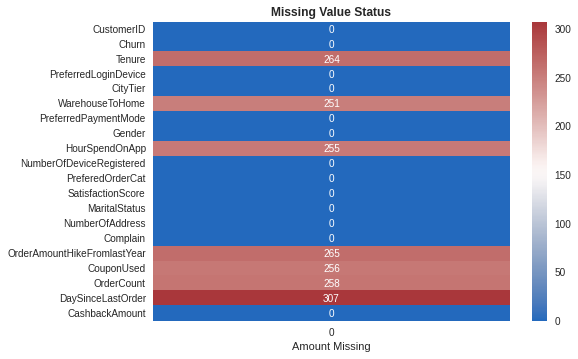

In [ ]:
plt.title('Missing Value Status',fontweight='bold')
ax = sns.heatmap(data.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
ax.set_xlabel('Amount Missing')
plt.show()

In [ ]:
percentage_of_null_values = ((data.isnull().sum())*100/len(data)).sort_values(ascending = False)
percentage_of_null_values

DaySinceLastOrder              5.452931
OrderAmountHikeFromlastYear    4.706927
Tenure                         4.689165
OrderCount                     4.582593
CouponUsed                     4.547069
HourSpendOnApp                 4.529307
WarehouseToHome                4.458259
CustomerID                     0.000000
MaritalStatus                  0.000000
Complain                       0.000000
NumberOfAddress                0.000000
PreferedOrderCat               0.000000
SatisfactionScore              0.000000
Churn                          0.000000
NumberOfDeviceRegistered       0.000000
Gender                         0.000000
PreferredPaymentMode           0.000000
CityTier                       0.000000
PreferredLoginDevice           0.000000
CashbackAmount                 0.000000
dtype: float64

In [ ]:
null_values = ((data.isnull().sum())).sort_values(ascending = False)
null_values

DaySinceLastOrder              307
OrderAmountHikeFromlastYear    265
Tenure                         264
OrderCount                     258
CouponUsed                     256
HourSpendOnApp                 255
WarehouseToHome                251
CustomerID                       0
MaritalStatus                    0
Complain                         0
NumberOfAddress                  0
PreferedOrderCat                 0
SatisfactionScore                0
Churn                            0
NumberOfDeviceRegistered         0
Gender                           0
PreferredPaymentMode             0
CityTier                         0
PreferredLoginDevice             0
CashbackAmount                   0
dtype: int64

Dapat dilihat terdapat 7 feature memiliki missing value dengan presentase > 4%, sehingga harus dilakukan penyesuaian agar tidak bermasalah untuk model. Sebelum memutuskan akan diselesaikan dengan cara seperti apa, kita harus mengetahui terlebih dahulu potensi penyebab data tersebut missing.

#### Missing Value : DaySinceLastOrder

In [ ]:
data["DaySinceLastOrder"].unique()

array([ 5.,  0.,  3.,  7.,  2.,  1.,  8.,  6.,  4., 15.,  9., 11., 10.,
       nan, 13., 12., 17., 16., 14., 30., 46., 18., 31.])

DaySinceLastOrder merupakan rentang hari sejak transaksi terakhir, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang DaySinceLastOrder yang missing. 

In [ ]:
data_null = data[data['DaySinceLastOrder'].isna()].copy()
data_null

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
88,50089,0,24.0,Mobile Phone,1,14.0,Debit Card,Male,2.0,4,Fashion,4,Divorced,6,0,16.0,1.0,4.0,NaN,224.90
97,50098,0,10.0,Computer,1,17.0,UPI,Male,2.0,3,Fashion,2,Married,2,1,14.0,0.0,1.0,NaN,221.85
126,50127,0,12.0,Computer,1,8.0,Cash on Delivery,Female,3.0,3,Fashion,3,Single,1,0,25.0,10.0,11.0,NaN,209.38
146,50147,1,10.0,Computer,1,35.0,Debit Card,Male,2.0,3,Fashion,4,Divorced,2,1,12.0,5.0,9.0,NaN,218.49
151,50152,0,2.0,Mobile Phone,1,28.0,Debit Card,Female,3.0,2,Fashion,4,Married,8,0,18.0,5.0,6.0,NaN,219.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591,55592,0,6.0,Mobile Phone,3,8.0,E wallet,Female,3.0,4,Fashion,1,Married,3,0,20.0,1.0,6.0,NaN,229.22
5608,55609,0,15.0,Mobile Phone,3,10.0,Debit Card,Male,3.0,5,Laptop & Accessory,4,Married,4,0,12.0,2.0,2.0,NaN,214.38
5610,55611,0,9.0,Mobile Phone,2,33.0,Debit Card,Female,3.0,4,Fashion,1,Single,3,1,17.0,2.0,2.0,NaN,213.37
5623,55624,0,5.0,Computer,1,12.0,Credit Card,Male,4.0,4,Laptop & Accessory,5,Single,2,0,20.0,2.0,2.0,NaN,224.36


In [ ]:
data_null[data_null['OrderCount']<1]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


In [ ]:
data_null[data_null['OrderCount'].isna()]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


Dapat dilihat untuk nilai DaySinceLastOrder yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : OrderAmountHikeFromlastYear

In [ ]:
data["OrderAmountHikeFromlastYear"].unique()

array([11., 15., 14., 23., 22., 16., 12., nan, 13., 17., 18., 24., 19.,
       20., 21., 25., 26.])

OrderAmountHikeFromlastYear merupakan Kenaikan presentase transaksi dari tahun lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang OrderAmountHikeFromlastYear yang missing.

In [ ]:
data_null = data[data['OrderAmountHikeFromlastYear'].isna()].copy()
data_null

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
10,50011,1,4.0,Mobile Phone,1,18.0,Cash on Delivery,Female,2.0,3,Others,3,Divorced,2,0,NaN,9.0,15.0,8.0,295.45
40,50041,0,23.0,Mobile Phone,1,17.0,Debit Card,Female,2.0,3,Others,4,Single,4,0,NaN,2.0,4.0,4.0,299.26
65,50066,0,25.0,Mobile Phone,1,6.0,Debit Card,Male,3.0,4,Others,3,Divorced,1,0,NaN,1.0,11.0,9.0,299.99
106,50107,0,15.0,Mobile Phone,1,10.0,Cash on Delivery,Male,2.0,3,Others,2,Divorced,2,0,NaN,0.0,11.0,15.0,292.32
108,50109,0,23.0,Mobile Phone,3,6.0,Credit Card,Female,3.0,3,Others,2,Married,4,0,NaN,1.0,1.0,6.0,295.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,55535,0,61.0,Mobile Phone,3,28.0,Debit Card,Female,4.0,4,Grocery,1,Married,6,1,NaN,1.0,2.0,1.0,303.75
5537,55538,0,23.0,Computer,1,9.0,Debit Card,Male,3.0,4,Others,1,Married,5,0,NaN,5.0,5.0,4.0,316.61
5561,55562,0,29.0,Mobile Phone,2,33.0,UPI,Male,4.0,2,Others,4,Married,6,1,NaN,2.0,2.0,5.0,321.36
5597,55598,0,13.0,Computer,1,16.0,Debit Card,Male,3.0,4,Others,1,Single,4,0,NaN,2.0,2.0,4.0,319.31


In [ ]:
data_null[data_null['OrderCount']<1]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


In [ ]:
data_null[data_null['OrderCount'].isna()]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


Dapat dilihat untuk nilai OrderAmountHikeFromlastYear yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : Tenure

In [ ]:
data["Tenure"].unique()

array([ 4., nan,  0., 13., 11.,  9., 19., 20., 14.,  8., 18.,  5.,  2.,
       30.,  1., 23.,  3., 29.,  6., 26., 28.,  7., 24., 25., 10., 15.,
       22., 27., 16., 12., 21., 17., 50., 60., 31., 51., 61.])

Tenure merupakan masa berlangganan dari pelanggan, Pelanggan baru sudah direpresentasikan dengan nilai 0, kemungkinan nilai 'nan' karena tidak terinput.

#### Missing Value : OrderCount

In [ ]:
data["OrderCount"].unique()

array([ 1.,  6.,  2., 15.,  4.,  7.,  3.,  9., nan, 11.,  5., 12., 10.,
        8., 13., 14., 16.])

OrderCount merupakan Total order pada bulan lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan terhadap adanya peningkatan transaksi yang dilakukan untuk data yang OrderCount yang missing.

In [ ]:
data_null = data[data['OrderCount'].isna()].copy()
data_null

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
64,50065,0,24.0,Mobile Phone,1,9.0,Credit Card,Female,3.0,3,Grocery,4,Single,4,0,18.0,0.0,NaN,0.0,237.34
90,50091,0,14.0,Mobile Phone,3,12.0,Debit Card,Female,3.0,3,Fashion,2,Single,4,1,18.0,0.0,NaN,0.0,235.91
110,50111,0,16.0,Mobile Phone,3,22.0,E wallet,Female,3.0,3,Grocery,2,Divorced,6,1,22.0,0.0,NaN,9.0,260.64
120,50121,0,4.0,Computer,1,9.0,Credit Card,Male,3.0,3,Fashion,3,Married,10,0,12.0,1.0,NaN,2.0,236.75
143,50144,0,18.0,Mobile Phone,1,26.0,Credit Card,Male,3.0,3,Grocery,2,Divorced,1,1,14.0,0.0,NaN,10.0,234.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,55566,0,5.0,Computer,1,17.0,Credit Card,Female,3.0,4,Fashion,3,Married,6,0,21.0,4.0,NaN,9.0,235.31
5581,55582,0,21.0,Computer,1,8.0,Credit Card,Female,4.0,4,Fashion,4,Married,2,0,19.0,1.0,NaN,13.0,244.57
5590,55591,0,12.0,Mobile Phone,1,17.0,Credit Card,Female,4.0,6,Fashion,3,Married,5,0,13.0,1.0,NaN,12.0,257.06
5621,55622,1,14.0,Mobile Phone,3,35.0,E wallet,Male,3.0,5,Fashion,5,Married,6,1,14.0,3.0,NaN,1.0,233.54


In [ ]:
data_null[data_null['OrderAmountHikeFromlastYear']<1]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


In [ ]:
data_null[data_null['OrderAmountHikeFromlastYear'].isna()]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


Dapat dilihat untuk nilai OrderCount yang missing, seluruhnya memiliki nilai OrderAmountHikeFromlastYear > 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : CouponUsed

In [ ]:
data["CouponUsed"].unique()

array([ 1.,  0.,  4.,  2.,  9.,  6., 11., nan,  7., 12., 10.,  5.,  3.,
       13., 15.,  8., 14., 16.])

CouponUsed merupakan Total penggunanaan kupon pada bulan lalu, nilai 'nan' bisa jadi karena pelanggan baru atau pelanggan tersebut baru pertama kali melakukan transaksi. Oleh karena itu untuk membuktikan asumsi tersebut dilakukan pengecekan total order yang pernah dilakukan untuk data yang OrderAmountHikeFromlastYear yang missing.

In [ ]:
data_null = data[data['CouponUsed'].isna()].copy()
data_null

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
61,50062,0,13.0,Mobile Phone,1,10.0,Credit Card,Female,2.0,3,Others,3,Divorced,2,0,14.0,NaN,9.0,9.0,290.33
62,50063,0,28.0,Mobile Phone,1,20.0,Credit Card,Male,3.0,2,Others,4,Single,9,0,11.0,NaN,2.0,15.0,287.22
69,50070,0,18.0,Computer,1,8.0,Credit Card,Male,3.0,4,Grocery,2,Divorced,10,0,23.0,NaN,11.0,8.0,267.92
112,50113,0,25.0,Computer,3,8.0,Debit Card,Male,3.0,4,Others,3,Single,2,1,18.0,NaN,15.0,12.0,290.68
138,50139,0,19.0,Mobile Phone,3,8.0,Cash on Delivery,Female,3.0,5,Grocery,4,Divorced,4,1,12.0,NaN,7.0,7.0,268.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,55355,0,21.0,Mobile Phone,3,9.0,Debit Card,Female,3.0,2,Grocery,4,Married,8,0,15.0,NaN,2.0,3.0,284.72
5355,55356,0,23.0,Mobile Phone,1,8.0,Debit Card,Male,3.0,4,Grocery,3,Single,6,0,15.0,NaN,2.0,1.0,278.79
5461,55462,0,31.0,Computer,3,9.0,Credit Card,Male,3.0,4,Grocery,4,Married,6,0,23.0,NaN,15.0,15.0,287.91
5470,55471,0,31.0,Computer,1,22.0,Debit Card,Male,3.0,4,Grocery,3,Married,4,1,15.0,NaN,3.0,3.0,282.87


In [ ]:
data_null[data_null['OrderCount']<1]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


In [ ]:
data_null[data_null['OrderCount'].isna()]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount


Dapat dilihat untuk nilai CouponUsed yang missing, seluruhnya memiliki nilai ordercount >= 1. Artinya data tersebut bukan merepresentasikan pelanggan baru atau pelanggan yang pertama kali melakukan transaksi. Dimungkinkan missing value disebabkan karena data tidak terinput.

#### Missing Value : HourSpendOnApp

In [ ]:
data["HourSpendOnApp"].unique()

array([ 3.,  2., nan,  1.,  0.,  4.,  5.])

HourSpendOnApp merupakan lama waktu pelanggan online di aplikasi, Pelanggan baru sudah direpresentasikan dengan nilai 0, kemungkinan nilai 'nan' karena tidak terinput.

#### Missing Value : WarehouseToHome

In [ ]:
data["WarehouseToHome"].unique()

array([  6.,   8.,  30.,  15.,  12.,  22.,  11.,   9.,  31.,  18.,  13.,
        20.,  29.,  28.,  26.,  14.,  nan,  10.,  27.,  17.,  23.,  33.,
        19.,  35.,  24.,  16.,  25.,  32.,  34.,   5.,  21., 126.,   7.,
        36., 127.])

WarehouseToHome merupakan Jarak gudang ke alamat pelanggan, kemungkinan nilai 'nan' karena tidak terinput.

Text(0, 0.5, 'Values')

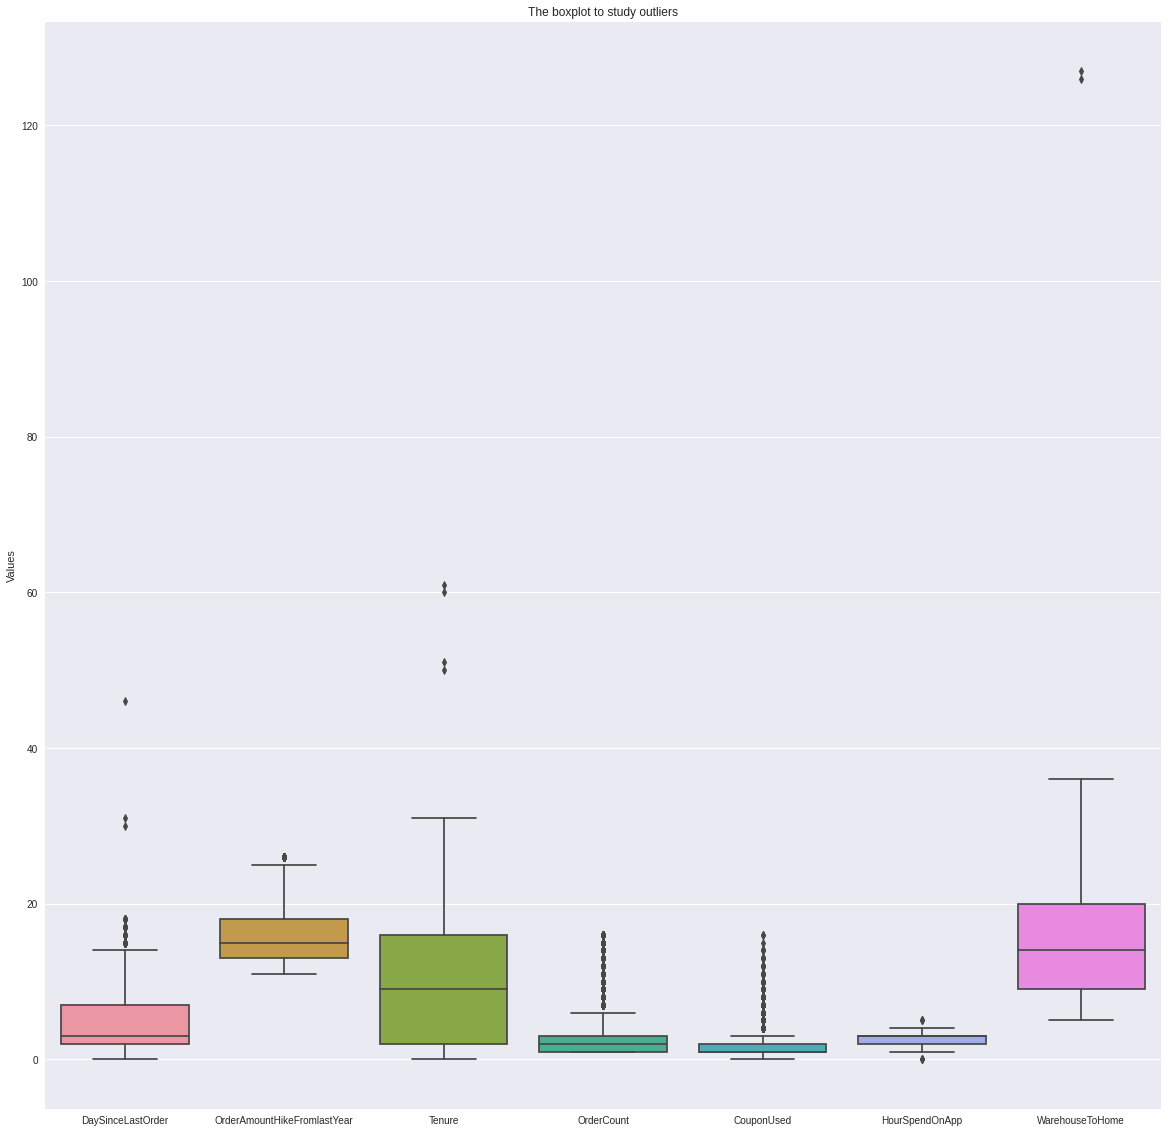

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(data=data[['DaySinceLastOrder','OrderAmountHikeFromlastYear','Tenure','OrderCount','CouponUsed','HourSpendOnApp','WarehouseToHome']])
plt.title('The boxplot to study outliers')
plt.ylabel('Values')

In [ ]:
data[['DaySinceLastOrder','OrderAmountHikeFromlastYear','Tenure','OrderCount','CouponUsed','HourSpendOnApp','WarehouseToHome']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DaySinceLastOrder,5323.0,4.543491,3.654433,0.0,2.0,3.0,7.0,46.0
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.0,15.0,18.0,26.0
Tenure,5366.0,10.189899,8.557241,0.0,2.0,9.0,16.0,61.0
OrderCount,5372.0,3.008004,2.939680,1.0,1.0,2.0,3.0,16.0
CouponUsed,5374.0,1.751023,1.894621,0.0,1.0,1.0,2.0,16.0
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.0,3.0,3.0,5.0
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.0,14.0,20.0,127.0


Dari grafik dan tabel diatas, didapatkan bahwa feature yang memiliki missing value adalah feature yang memiliki nilai numerik. Untuk itu akan dilakukan handling missing value dengan beberapa cara dengan mempertimbangkan rentang nilai min - max, rentang Q1 - Q3 dan hubungan antar feature akan disesuaikan dengan kondisi missing value dari masing - masing feature, yaitu:

1. 'DaySinceLastOrder' memiliki rentang nilai 0 - 46 dan range antara Q1 hingga Q3 dengan nilai 2 - 7 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model. 


2. 'OrderAmountHikeFromlastYear' memiliki rentang nilai 11 - 26 dan range antara Q1 hingga Q3 dengan nilai 13 - 18 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


3. 'Tenure' memiliki rentang nilai 0 - 61 dan range antara Q1 hingga Q3 dengan nilai 2 - 16 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.  


4. 'OrderCount' memiliki rentang nilai 1 - 16 dan range antara Q1 hingga Q3 dengan nilai 1 - 3 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


5. 'CouponUsed' memiliki rentang nilai 0 - 16 dan range antara Q1 hingga Q3 dengan nilai 1 - 2 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.


6. 'HourSpendOnApp' memiliki rentang nilai 0 - 5 dan range antara Q1 hingga Q3 dengan nilai 2 - 3 serta terdapat outlier dalam data, dengan mempertimbang kecilnya range antara nilai minimum dan maksimum maka akan dilakukan pengisian missing value menggunakan metode simple imputer dengan nilai median.


7. 'WarehouseToHome' memiliki rentang nilai 5 - 127 dan range antara Q1 hingga Q3 dengan nilai 9 - 20 serta terdapat outlier dalam data, dengan memperhitungkan lebarnya range antara nilai minimum dan maksimum serta hubungan dengan fitur lainnya maka akan dilakukan pengisian missing value menggunakan metode iterative imputer dengan regression model.

Iterative imputer merupakan salah satu metode pengisian missing value yang menggunakan fitur lain yang ada dalam data untuk membuat regresi model sehingga menghasilkan suatu nilai untuk missing value tersebut.

Untuk pengisian missing value sesuai penjelasan diatas akan dilakukan bersamaan dengan encoding menggunakan transformer.

### Handling Missing Value dan Imputasi

In [ ]:
cat_features = ['Tenure','WarehouseToHome','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']
cont_features = ['HourSpendOnApp']

In [ ]:
def imputation (data, 
                #x_test,
                cont_features,
                cat_features,
                cont_strategy = 'median',
                cat_strategy = 'most_frequent'
                ):

#initializa object imputer
  imputerCat = SimpleImputer(missing_values=np.nan, strategy= cat_strategy)
  imputerCont = SimpleImputer(missing_values=np.nan, strategy= cont_strategy)

#fit to data train
  imputerCont.fit(data[cont_features])
  imputerCat.fit(data[cat_features])

#transfrom to data
  data[cont_features] = imputerCont.transform(data[cont_features])
  data[cat_features] = imputerCat.transform(data[cat_features])

  return data

In [ ]:
data = imputation(data,cont_features, cat_features)

In [ ]:
data

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,1.0,Mobile Phone,1,8.0,UPI,Male,3.0,4,Mobile Phone,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,1.0,Mobile Phone,1,30.0,Debit Card,Male,2.0,4,Mobile Phone,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Mobile Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Mobile Phone,1,12.0,Credit Card,Male,3.0,3,Mobile Phone,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,3.0,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


# Methodology (Machine Learning):
Pada bagian ini, kami akan membuat model yang dapat melakukan *customer segmentation*. *Customer segmentation* sendiri merupakan masalah *unsupervised* sehingga data kami tidak ada label, melainkan nanti kami sendiri yang akan memberikan label. Algoritma yang dapat digunakan:
- RFM Sementation
- K-Means
- Agglomerative Clustering

## Data (Machine Learning):
- Unit Analysis:
  - Customer behavior: Customer Unique ID

- Features:
  - Recency: Mengukur dari kapan terakhir kali seorang customer melakukan transaksi.  

  - Frequency: Mengukur dari seberapa sering seorang customer melakukan transaksi.

  - Monetary: Mengukur dari total transaksi yang dilakukan seorang customer.

## RFM Segmentation 
RFM adalah singkatan dari *Recency, Frequency,* dan *Monetary*. Tiap faktor menyesuaikan dengan ciri-ciri dari *customer*. Metrik RFM ini merupakan indikator penting dari segmentasi perilaku *customer* karena *frequency* dan *monetary* memengaruhi *customer lifetime value*, dan *recency* memengaruhi *engagement rate.*



In [ ]:
cust_df = data.copy()
cust_df = cust_df.rename(columns={"DaySinceLastOrder": "recency", "OrderCount": "frequency", 'CashbackAmount':'monetary'})

### Recency Segmentation
*Recency* merupakan perhitungan waktu terakhir seorang *customer* melakukan transaksi dalam satuan hari. Segmentasi berdasarkan *recency* ini dilakukan dengan membuat kelompok berdasarkan nilai *quartile* (Q1, Q2, dan Q3) sehingga terdapat 4 kelompok. Nama dari kelompok tersebut adalah *active, warm, cold,* dan *inactive* yang diambil berdasarkan *market temperature*.     

#### Scoring

In [ ]:
# Calculate Q1, Q2, Q3 from Recency
cust_df['recency'].quantile([0.25, 0.5, 0.75])

0.25    2.0
0.50    3.0
0.75    7.0
Name: recency, dtype: float64

In [ ]:
# Recency Segmentation using quartile and scoring
label_r = range(4, 0, -1)
group_r = pd.qcut(cust_df['recency'], q=4, labels=label_r)
cust_df['R'] = group_r.values

In [ ]:
cust_df["R"].unique()

[2, 4, 3, 1]
Categories (4, int64): [4 < 3 < 2 < 1]

In [ ]:
cust_df[cust_df['R'].isna()]

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,frequency,recency,monetary,R


In [ ]:
# Group by R
df_R = cust_df.groupby(['R']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the R segment
df_R.loc[df_R['R'] == 4, 'R_group'] = 'active'
df_R.loc[df_R['R'] == 3, 'R_group'] = 'warm'
df_R.loc[df_R['R'] == 2, 'R_group'] = 'cold'
df_R.loc[df_R['R'] == 1, 'R_group'] = 'innactive'

# Calculate the percentage
df_R['R_percent'] = round(df_R['n_customers']/df_R['n_customers'].sum()*100, 2)

df_R

,R,n_customers,R_group,R_percent
0,4,1902,active,33.78
1,3,1207,warm,21.44
2,2,1219,cold,21.65
3,1,1302,innactive,23.13


> Keterangan :
> - *Active* = *Recency* -nya lebih kecil atau sama dengan dari 2 hari (Q1)
- *Warm* = *Recency* -nya diantara 3 hari (Q2)
- *Cold* = *Recency* -nya diantara 7 dari (Q3)
- *Inactive* = *Recency* -nya lebih dari 7 hari (Q3)

#### Visualization

In [ ]:
recency_cust = cust_df['CustomerID'].groupby(cust_df['recency']).count()

# Visualization
fig = go.Figure()
# Create Layout
fig.update_layout(
    title='Recency Segmentation',
    xaxis_title='Days (since last transactions)',
    yaxis_title='Total Customers',
    showlegend=False)
# Plot Area Chart
fig.add_trace(go.Scatter(x=recency_cust.index, 
                         y=recency_cust.values, 
                         fill='tozeroy', 
                         mode='none'))
# Plot Line
fig.add_trace(go.Scatter( x=[2, 2], y=[0,1200],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q1 (2 days)'))
fig.add_trace(go.Scatter( x=[3, 3], y=[0,1000],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q2 (3 days)'))
fig.add_trace(go.Scatter( x=[7, 7], y=[0,1200],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q3 (7 days)'))
# Annotation
fig.add_annotation(x=2, y=1200,
            text="Active: 33.78 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=5.5, y=1000,
            text="Warm: 21.44 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=7, y=1200,
            text="Cold: 21.65 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=12, y=1000,
            text="Inactive:  23.13 %",
            showarrow=False,
            yshift=10)
fig.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *recency*-nya. Terdapat 4 segmen yaitu: 
- *Active* : Terdapat 1902 *customer* atau 33.78 % *customer* yang melakukan transaksi dibawah 2 hari
- *Warm* : Terdapat 1207 *customer* atau 21.44 % *customer* yang melakukan transaksi diantara 3 hari
- *Cold* : Terdapat 1219 *customer* atau 21.65 % *customer* yang melakukan transaksi diantara 7 hari
- *Inactive* : Terdapat 1302 *customer* atau 23.13 % *customer* yang melakukan transaksi diatas 7 hari

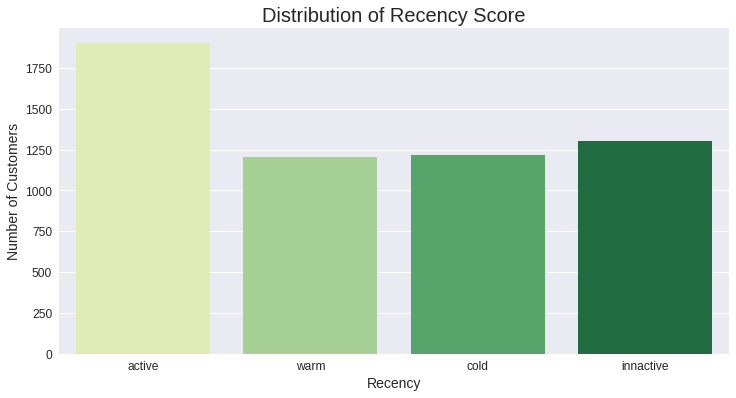

In [ ]:
# Distribution of Recency
plt.figure(figsize=(12, 6))
sns.barplot(x='R_group', y='n_customers', data=df_R, palette='YlGn')
plt.title('Distribution of Recency Score',fontsize=20)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas, mayoritas *customer ecommerse* berada pada segmen *Active*. Hal ini berarti mereka aktif melakukan transaksi dibawah 2 hari sejak melakukan transaksi terakhir. 

>  Segmentasi berdasarkan *recency* ini penting karena semakin baru seorang *customer* melakukan transaksi di *ecommerse*, maka semakin besar kecendrungan bahwa ia akan mengingat *ecommerse* dan melakukan transaksi lagi, seperti pada segmen *Active*. 

### Frequency Segmentation
*Frequency* merupakan perhitungan seberapa sering seorang *customer* melakukan transaksi. Segmentasi berdasarkan *frequency* ini dilakukan dengan membuat 4 kelompok dengan cara mengurutkan *frequency* tiap customer lalu membagi 4 sama besar, cara ini digunakan karena mayoritas dari *customer* hanya melakukan transaksi sebanyak 1 kali sehingga nilainya akan condong ke yang paling banyak. Nama dari segmentasinya adalah *low frequency*, *medium frequency*, *high frequency*, dan *special frequency*.

#### Scoring

In [ ]:
# Frequency segmentation
def F_segmentation(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4

cust_df['F'] = cust_df['frequency'].apply(F_segmentation)
cust_df['F'].value_counts()

2    2283
1    1751
4    1225
3     371
Name: F, dtype: int64

In [ ]:
cust_df["F"].unique()

array([1, 4, 2, 3])

In [ ]:
# Group by F
df_F = cust_df.groupby(['F']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the F segmentation
df_F.loc[df_F['F'] == 4, 'F_group'] = 'special'
df_F.loc[df_F['F'] == 3, 'F_group'] = 'high'
df_F.loc[df_F['F'] == 2, 'F_group'] = 'medium'
df_F.loc[df_F['F'] == 1, 'F_group'] = 'low'

# Calculate the percentage
df_F['F_percent'] = round(df_F['n_customers']/df_F['n_customers'].sum()*100, 2)

df_F

,F,n_customers,F_group,F_percent
0,1,1751,low,31.10
1,2,2283,medium,40.55
2,3,371,high,6.59
3,4,1225,special,21.76


> Keterangan :
- Special Frequency : Lebih dari 4 kali melakukan transaksi
- High Frequency : 3 kali melakukan transaksi
- Medium Frequency : 2 kali melakukan transaksi
- Low Frequency : Hanya 1 kali melakukan transaksi 

#### Visualization

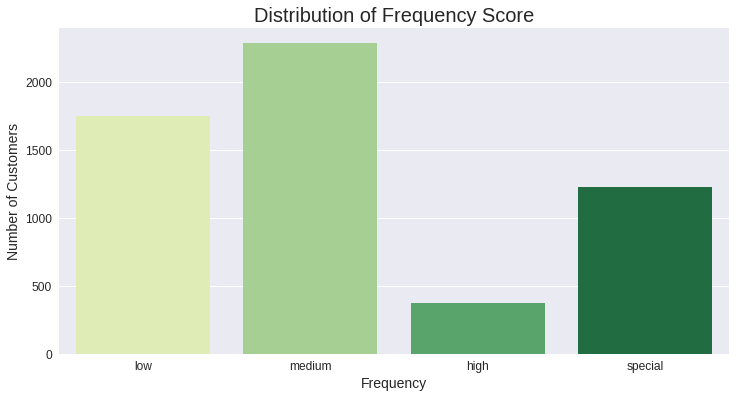

In [ ]:
# Distribution of Frquency
plt.figure(figsize=(12, 6))
sns.barplot(x='F_group', y='n_customers', data=df_F, palette='YlGn')
plt.title('Distribution of Frequency Score',fontsize=20)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *frequency*-nya. Terdapat 4 segmen yaitu: 
- *Special Frequency* : Terdapat 1225 atau 21.76 % *customer* yang melakukan lebih dari 4 kali transaksi
- *High Frequency* : Terdapat 371 atau 6.59 % *customer* yang melakukan transaksi sebanyak 3 kali.
- *Medium Frequency* : Terdapat 2283 atau 40.55 % *customer* yang melakukan transaksi sebanyak 2 kali
- *Low Frequency* : Terdapat 1751 atau 31.10 % *customer* yang melakukan transaksi sebanyak 1 kali

> Mayoritas customer ecommerse berada pada segmen Medium Frequency, yang artinya hanya melakukan transaksi sebanyak 2 kali saja.

> Dengan melakukan segmentasi berdasarkan frequency, kita dapat melihat customer mana yang menggunakan ecommerse berulang kali untuk melakukan transaksi atau dengan kata lain customer yang loyal.

### Monetary Segmentation
*Monetary* merupakan kekuatan belanja atau total pembelian dari seorang *customer*. Segmentasi berdasarkan *monetary* ini dilakukan dengan membuat kelompok berdasarkan nilai *quartile* (Q1, Q2, dan Q3) sehingga terdapat 4 kelompok. Nama dari segmentasinya adalah *low value*, *medium value*, *high value*, dan *special value*.

#### Scoring

In [ ]:
# Calculate Q1, Q2, Q3 from Monetary
round(cust_df['monetary'].quantile([0.25, 0.5, 0.75]))

0.25    146.0
0.50    163.0
0.75    196.0
Name: monetary, dtype: float64

In [ ]:
# Scoring for M values
labels_m = range(1, 5)
group_m = pd.qcut(cust_df['monetary'], q = 4, labels = labels_m)
cust_df['M'] = group_m.values

In [ ]:
cust_df["M"].unique()

[2, 1, 4, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

In [ ]:
# Group by M
df_M = cust_df.groupby(['M']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the M Segmentation
df_M.loc[df_M['M'] == 1, 'M_group'] = 'low values'
df_M.loc[df_M['M'] == 2, 'M_group'] = 'medium values'
df_M.loc[df_M['M'] == 3, 'M_group'] = 'high values'
df_M.loc[df_M['M'] == 4, 'M_group'] = 'special values'

# Calculate the percentage
df_M['M_percent'] = round(df_M['n_customers']/df_M['n_customers'].sum()*100, 2)

df_M

,M,n_customers,M_group,M_percent
0,1,1409,low values,25.03
1,2,1406,medium values,24.97
2,3,1407,high values,24.99
3,4,1408,special values,25.01


> Keterangan :
> - *Special Values* = *Monetary*-nya lebih dari R\$ 196 (Q3)
- *High Values* = *Monetary*-nya diantara R\$ 163 (Q2) - R\$ 196
- *Medium Values* = *Monetary*-nya diantara R\$ 146 (Q1) - R\$ 163 
- *Low Values* = *Monetary*-nya kurang dari R\$ 146

#### Visualization

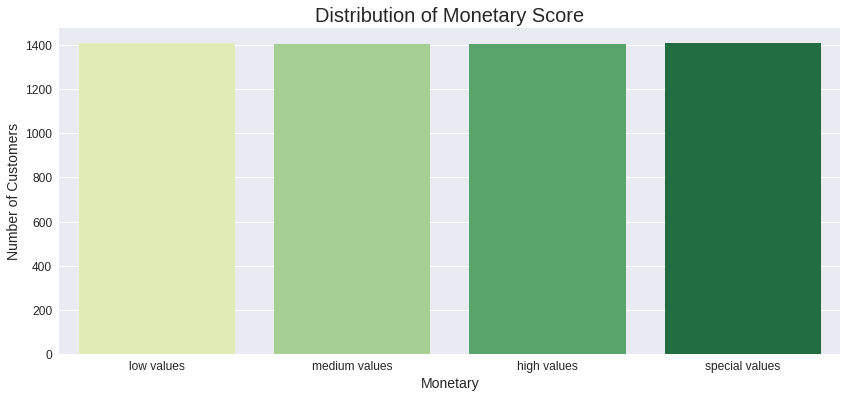

In [ ]:
# Distribution of Monetary
plt.figure(figsize=(14, 6))
sns.barplot(x='M_group', y='n_customers', data=df_M, palette='YlGn')
plt.title('Distribution of Monetary Score',fontsize=20)
plt.xlabel('Monetary',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> Berdasarkan grafik diatas dapat terlihat pembagian segmentasi *customer* berdasarkan nilai *monetary*-nya. Terdapat 4 segmen yaitu: 
- *Special Values* : Terdapat 1408 atau 25.01 % *customer* yang melakukan transaksi dengan total lebih dari R\$ 196
- *High Values* : Terdapat 1407 atau 24.99 % *customer* yang melakukan transaksi dengan total R\$ 163 - R\$ 196
- *Medium Values* : Terdapat 1406 atau 24.97 % *customer* yang melakukan transaksi dengan total R\$ 163 - R\$ 146
- *Low Values* : Terdapat 1409 atau 25.03 % *customer* yang melakukan transaksi dengan total kurang dari R\$ 146

> nilai monetary setiap segmen memiliki persentase nilai yang sama 

> Dengan melakukan segmentasi berdasarkan monetary, kita dapat melihat customer mana yang melakukan jumlah transaksi paling besar dan paling sedikit. Dengan itu kita dapat melakukan pendekatan marketing yang berbeda sesuai segmennya.

### RFM Segmentation
Pada RFM Segmentation ini kami melakukan perhitungan skor segmentasinya dengan cara mengkombinasikan skor dari R, F, dan M menjadi sebuah kombinasi unik dalam bentuk string. Contohnya jika R = 1, F = 1, dan M = 1 maka RFM Segmentation Score nya menjadi 1 + 1 + 1 = 111



#### Calculate RFM Score

In [ ]:
# Combine the R, F, and M score
cust_df['RFM Score'] = cust_df['R'].astype(str) + cust_df['F'].astype(str) + cust_df['M'].astype(str)
cust_df['RFM Score']

0       212
1       411
2       311
3       311
4       311
       ... 
5625    222
5626    324
5627    223
5628    123
5629    323
Name: RFM Score, Length: 5630, dtype: object

#### RFM Segmentation based on the RFM Score

In [ ]:
# RFM Segmentation 
def segmentation(x):
    if re.search('444', x) or re.search('344', x): 
        return 'Best'
    elif re.search('2.4', x) or re.search('3.4', x) or re.search('4.4', x):
        return 'Big Spender'
    elif re.search('24.', x) or re.search('34.', x) or re.search('23.', x) or re.search('33.', x):
        return 'Loyal'
    elif re.search('41.', x):
        return 'New'
    elif re.search('4..', x) or re.search('3..', x):
        return 'Promising'
    elif re.search('111', x) or re.search('211', x) or re.search('112', x) or re.search('212', x):
        return 'Lost'
    elif re.search('1..', x) or re.search('2..', x):
        return 'Lost Potential'
    else:
        return 'Reguler'

cust_df['RFM Segment'] = cust_df['RFM Score'].apply(segmentation)
cust_df['RFM Segment'].value_counts()

Lost Potential    1671
Promising         1336
New                888
Big Spender        712
Loyal              501
Lost               346
Best               176
Name: RFM Segment, dtype: int64

In [ ]:
# Customer Segmentation Percentage
round(cust_df['RFM Segment'].value_counts(normalize=True)*100, 2)

Lost Potential    29.68
Promising         23.73
New               15.77
Big Spender       12.65
Loyal              8.90
Lost               6.15
Best               3.13
Name: RFM Segment, dtype: float64

In [ ]:
rfm_agg = cust_df.groupby('RFM Segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : 'mean',
    'RFM Segment' : 'count'
})

rfm_agg.round(2)

,recency,frequency,monetary,RFM Segment
RFM Segment,,,,
Best,2.62,8.36,230.97,176
Big Spender,3.20,2.57,244.79,712
Lost,6.13,1.00,141.28,346
Lost Potential,8.46,4.21,195.30,1671
Loyal,4.85,4.84,158.28,501
New,1.01,1.00,138.12,888
Promising,2.08,2.01,153.93,1336


#### Distribution

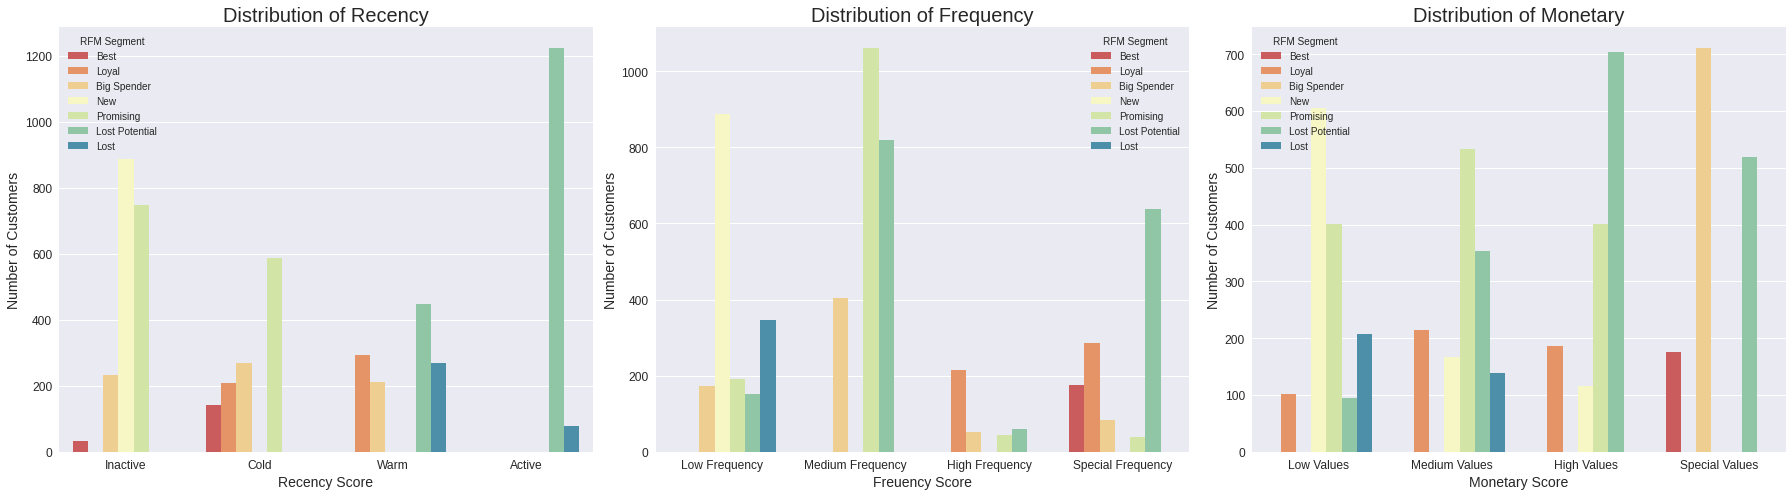

In [ ]:
segment = ['Best', 'Loyal', 'Big Spender', 'New', 'Promising', 'Lost Potential', 'Lost']
# Visualization for Recency, Freuency, Monetary score distribution by Customer Segmentation 2
plt.figure(figsize=(25, 7))

plt.subplot(131)
sns.countplot(x='R', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Recency',fontsize=20)
plt.xlabel('Recency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Inactive', 'Cold', 'Warm', 'Active'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(132)
sns.countplot(x='F', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Frequency',fontsize=20)
plt.xlabel('Freuency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Frequency', 'Medium Frequency', 'High Frequency', 'Special Frequency'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(133)
sns.countplot(x='M', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Monetary',fontsize=20)
plt.xlabel('Monetary Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Values', 'Medium Values', 'High Values', 'Special Values'], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

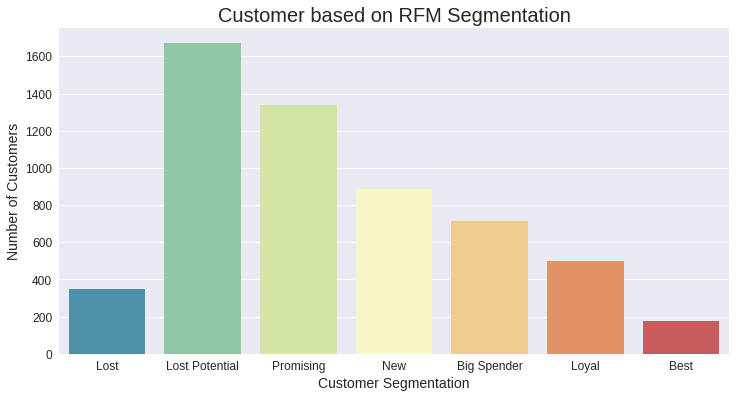

In [ ]:
segment2 = ['Lost', 'Lost Potential', 'Promising', 'New', 'Big Spender', 'Loyal', 'Best']
# Distribution of Customer Segmentation
plt.figure(figsize=(12,6))
sns.countplot(x='RFM Segment', data=cust_df, order=segment2, palette='Spectral_r')
plt.title('Customer based on RFM Segmentation',fontsize=20)
plt.xlabel('Customer Segmentation',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


> 

- Best : Customer yang melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi. 
- Loyal : Customer yang sudah melakukan transaksi lebih dari 4 kali. 
- Big Spender : Customer yang melakukan transaksi dengan total transaksi paling tinggi.
- New : Customer yang melakukan transaksi baru-baru ini dan baru bertransaksi sebanyak 1 kali.
- Promising : Customers yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.
- Lost Potential : Customers yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.
- Lost : Customers yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.

#### Scatter Plot 

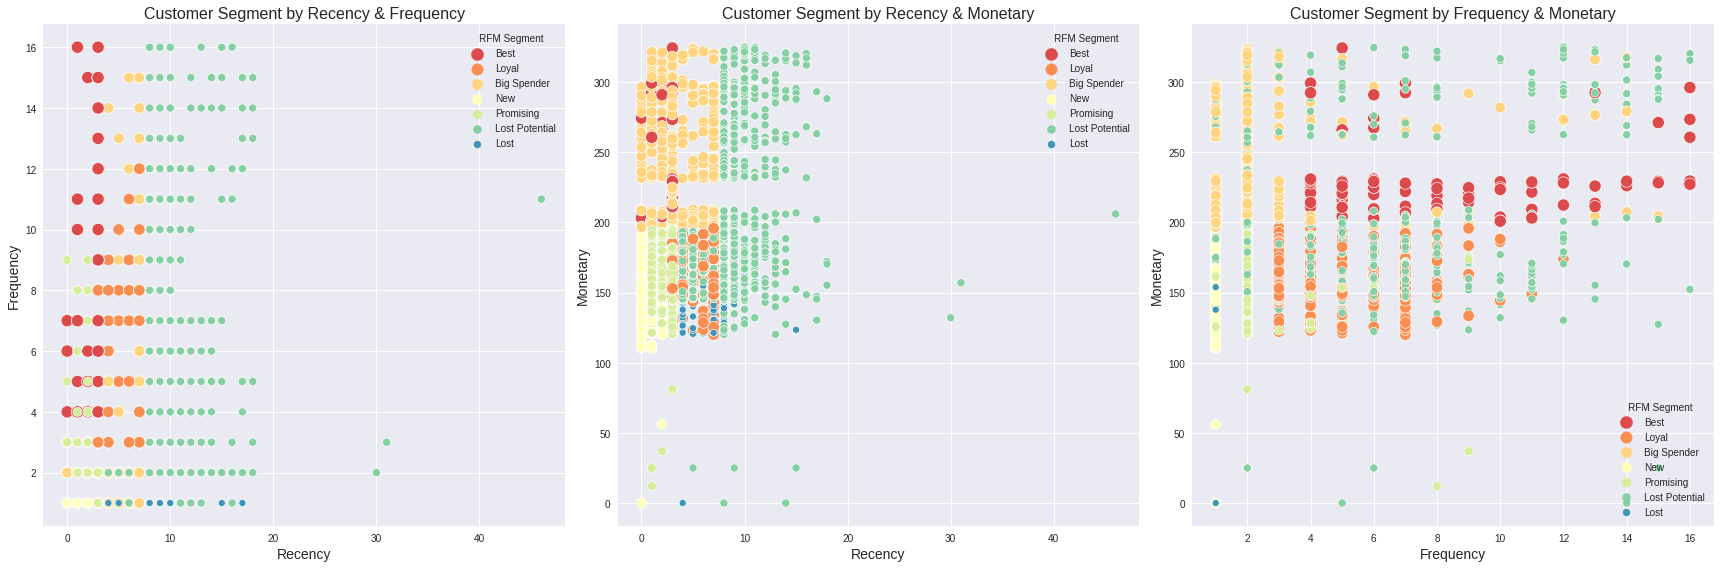

In [ ]:
# Scatter Plot for RFM segmentation 2
plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
sns.scatterplot(x='recency', 
                y='frequency', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment, 
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Frequency',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(132)
sns.scatterplot(x='recency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Monetary',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(133)
sns.scatterplot(x='frequency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment,
                palette='Spectral')
plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
def RFM_segmentation_score(x):
    if x == 'Best':
        return 7
    elif x == 'Loyal':
        return 6
    elif x == 'Big Spender':
        return 5
    elif x == 'New':
        return 4
    elif x == 'Promising':
        return 3
    elif x == 'Lost Potential':
        return 2
    else:
        return 1

cust_df['RFM Segment Score'] = cust_df['RFM Segment'].apply(RFM_segmentation_score)

#### 3D Visualization

In [ ]:
fig = px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'RFM Segment')
fig.show()

#### Calucalate Silhoutte Score

In [ ]:
# Define x
x = cust_df[['recency', 'frequency', 'monetary']]
# Scale
scaler = StandardScaler()
# Data Scale
x_scaled = scaler.fit_transform(x)
# Calculate Silhoutte Score
labels = cust_df['RFM Segment Score']
silhoutte_value = silhouette_score(x_scaled, labels)
print('Silhoutte Score for RFM:', silhoutte_value)

Silhoutte Score for RFM: 0.06673593068647679


## K-Means:
K-Means merupakan algoritma yang dapat digunakan untuk *clustering*. Algoritma K-Means menggunakan konsep jarak sama seperti algoritma KNN. Salah satu konsep jarak yang digunakan adalah *Euclidean*. Dikarenakan algortima K-Means menggunakan konsep jarak, maka kami harus melakukan *scaling* terhadap *feature* yang kami punya berhubung *feaature* tersebut *scalingnya* tidak sama. *Feature* yang kami punya menunjukkan adanya *outlier* dan kami tidak ingin data *outlier* tersebut memiliki pengaruh sehingga scaling yang dapat digunakan adalah *Standard Scaler*.

In [ ]:
## Data
x = cust_df[['recency', 'frequency', 'monetary']]

# Scale
scaler = StandardScaler()

# Data Scale
x_scaled = scaler.fit_transform(x)

In [ ]:
score = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  kmeans = KMeans(i)
  kmeans.fit(x_scaled)

  label = kmeans.labels_
  score.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score[i], 3))

Silhoutte Score untuk 2 Cluster 0.452
Silhoutte Score untuk 3 Cluster 0.41
Silhoutte Score untuk 4 Cluster 0.429
Silhoutte Score untuk 5 Cluster 0.452
Silhoutte Score untuk 6 Cluster 0.438
Silhoutte Score untuk 7 Cluster 0.339
Silhoutte Score untuk 8 Cluster 0.344


Text(0, 0.5, 'Silhoutte Score')

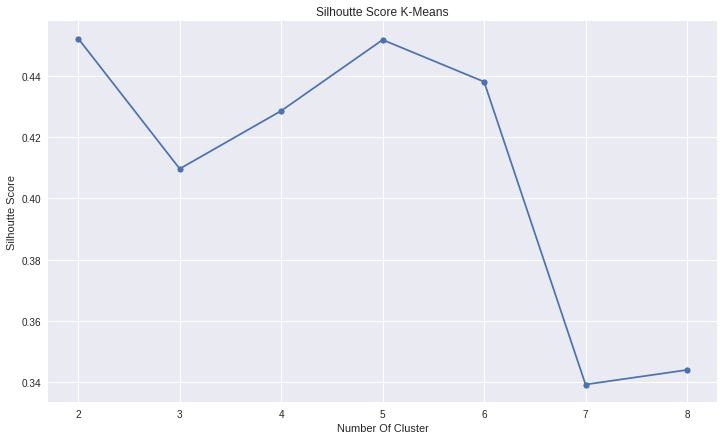

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score)
sns.scatterplot(number_of_clusters, score)

plt.title('Silhoutte Score K-Means')
plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

> Keterangan:
- *Silhoutte Score* terbaik didapatkan pada cluster 2
- Kami memutuskan untuk tidak menggunakan 2 *cluster* karena *cluster* yang terbentuk kemungkinan besar hanya *customer* dengan *frequency* 1 kali dengan *monetary* yang rendah dan *customer* diluar *cluster* tersebut
- Kami akan menggunakan 5 *cluster* karena 5 *cluster* memiliki nilai *silhoutte score* tertinggi setelah 2

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(x_scaled)

cust_df['label k-means'] = kmeans.labels_

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')

In [ ]:
label = cust_df['label k-means']
score = silhouette_score(x_scaled, label, metric = 'euclidean')
score

0.450164697272928

In [ ]:
def label(x):
  if x == 0:
    return 'New Comer'
  elif x == 1:
    return 'Lost'
  elif x == 2:
    return 'Big Spender'
  elif x == 3:
    return 'Medium Spender'
  else:
    return 'Loyal'

cust_df['label k-means'] = cust_df['label k-means'].apply(label)

In [ ]:
# Jumlah Customer setiap segment
cust_df['label k-means'].value_counts()

Lost              2998
New Comer          958
Medium Spender     784
Loyal              634
Big Spender        256
Name: label k-means, dtype: int64

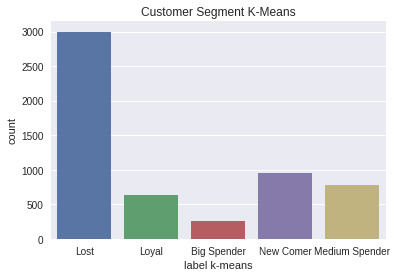

In [ ]:
## Visualisasi
plt.figure(figsize = (6,4))
sns.countplot(x='label k-means', data = cust_df)
plt.title('Customer Segment K-Means')
plt.show()

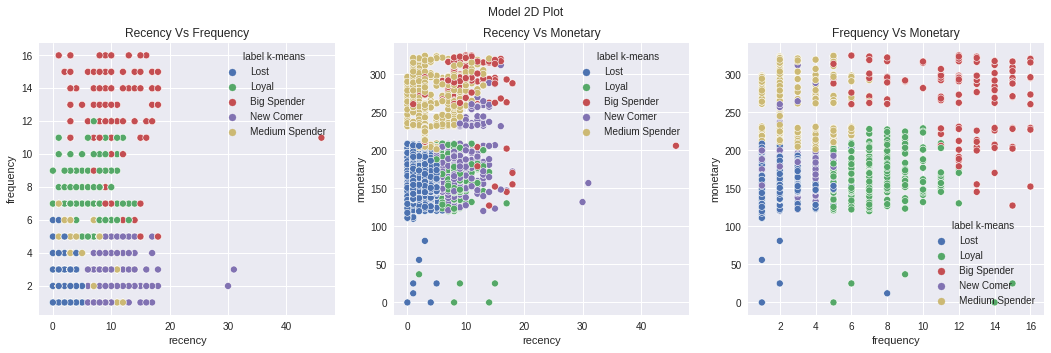

In [ ]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')

## Gaussian:
Gaussian merupakan salah satu algoritma *unsupervised learning* yang dapat digunakan untuk *clustering*. Konsep dari algoritma ini adalah menggunakan *Expectation Maximazation (EM)* untuk menentukan *mean* dan *variance* baru. Berikut cara kerja algoritma Gaussian:
1. Menentukan jumlah *cluster* yang ingin dibuat
2. Menentukan nilai *mean* dan *variance* dari setiap *cluster* secara *random*
3. Menghitung *probability* dari setiap data point untuk melihat data tersebut masuk kedalam *cluster* mana dengan menggunakan *Expectation Step*
4. Menentukan nilai *mean* dan *variance* yang baru dengan menggunakan *maximazation Step*
5. Menghitung *log-likelihood* untuk mengecek convergence
6. Mengulang step 3 sampai seterusnya hingga mendapatkan hasil yang stabil

Dikarenakan algoritma ini tidak menggunakan konsep jarak, melainkan menggunakan konsep *EM* maka tidak memerlukan scaling

In [ ]:
x = cust_df[['recency', 'frequency', 'monetary']]

In [ ]:
score2 = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  gsm = GaussianMixture(n_components=i)
  gsm.fit(x)

  label = gsm.predict(x)
  score2.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score2)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score2[i], 3))

Silhoutte Score untuk 2 Cluster 0.405
Silhoutte Score untuk 3 Cluster 0.363
Silhoutte Score untuk 4 Cluster 0.328
Silhoutte Score untuk 5 Cluster 0.175
Silhoutte Score untuk 6 Cluster 0.06
Silhoutte Score untuk 7 Cluster 0.062
Silhoutte Score untuk 8 Cluster 0.077


Text(0, 0.5, 'Silhoutte Score')

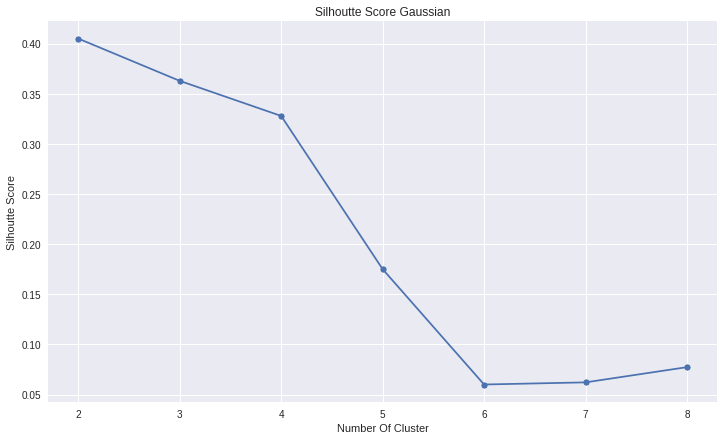

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score2)
sns.scatterplot(number_of_clusters, score2)

plt.title('Silhoutte Score Gaussian')
plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

In [ ]:
gsm = GaussianMixture(n_components=4)
gsm.fit(x)

cust_df['label gaussian'] = gsm.predict(x)

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label gaussian')

In [ ]:
cust_df['label gaussian'].value_counts()

2    3191
1    1356
0     628
3     455
Name: label gaussian, dtype: int64

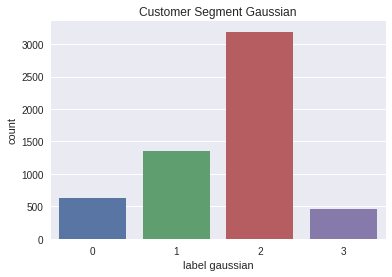

In [ ]:
## Visualisasi
plt.figure(figsize = (6,4))
sns.countplot(x='label gaussian', data = cust_df)
plt.title('Customer Segment Gaussian')
plt.show()

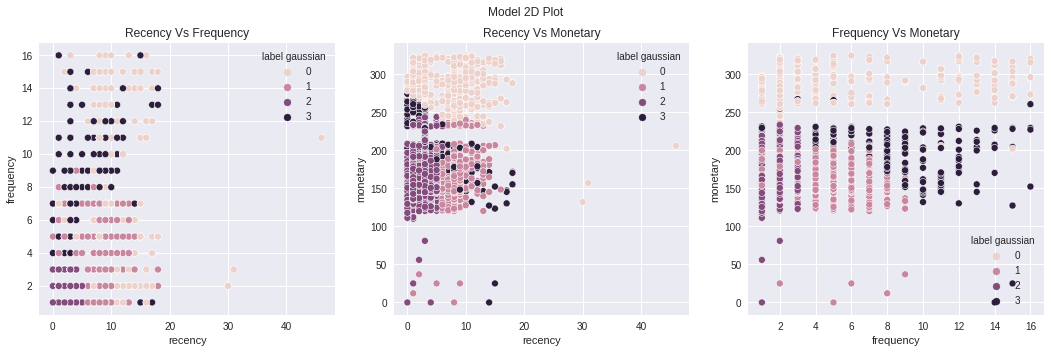

In [ ]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

## RFM Segmentation Analysis:
Tahap selanjutnya adalah menganalisa sifat dari setiap segmentasi agar dapat diberikan treatment yang sesuai dengan sifat tersebut

In [ ]:
# RFM Segmentation Group by for analysis
rfm_segment = cust_df.groupby(['RFM Segment', 'RFM Segment Score']).agg(
    n_customer = ('CustomerID', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('PreferredPaymentMode', lambda x: x.value_counts().index[0]),
    avg_review_score = ('SatisfactionScore', 'mean'),
    most_product_buy = ('PreferedOrderCat', lambda x: x.value_counts().index[0]),
).sort_values(by='RFM Segment Score', ascending=False)

rfm_segment

,,n_customer,mean_recency,min_recency,max_rencency,mean_freq,min_freq,max_freq,mean_monetary,min_monetary,max_monetary,most_payment_type,avg_review_score,most_product_buy
RFM Segment,RFM Segment Score,,,,,,,,,,,,,
Best,7,176,2.625000,0.0,3.0,8.357955,4.0,16.0,230.968920,200.96,324.43,Debit Card,3.051136,Fashion
Loyal,6,501,4.846307,3.0,7.0,4.842315,3.0,12.0,158.280918,120.11,196.19,Debit Card,2.972056,Laptop & Accessory
Big Spender,5,712,3.200843,0.0,7.0,2.567416,1.0,15.0,244.787219,196.67,324.26,Debit Card,3.005618,Fashion
New,4,888,1.010135,0.0,2.0,1.000000,1.0,1.0,138.116137,0.00,196.10,Debit Card,3.087838,Mobile Phone
Promising,3,1336,2.079341,0.0,3.0,2.006737,1.0,9.0,153.928451,12.00,196.37,Debit Card,3.058383,Mobile Phone
Lost Potential,2,1671,8.461999,4.0,46.0,4.210054,1.0,16.0,195.301556,0.00,324.99,Debit Card,3.115500,Laptop & Accessory
Lost,1,346,6.132948,4.0,17.0,1.000000,1.0,1.0,141.281647,0.00,163.22,Credit Card,3.080925,Laptop & Accessory


Text(0.5, 1.0, 'Recency per RFM Segment')

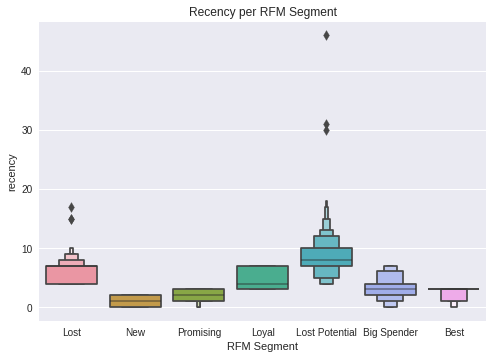

In [ ]:
sns.boxenplot(x=cust_df['RFM Segment'], y=cust_df['recency'])
plt.title('Recency per RFM Segment')

Text(0.5, 1.0, 'Frequency per RFM Segment')

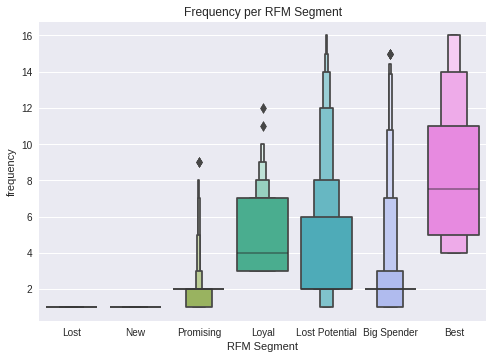

In [ ]:
sns.boxenplot(x=cust_df['RFM Segment'], y=cust_df['frequency'])
plt.title('Frequency per RFM Segment')

Text(0.5, 1.0, 'Monetary per RFM Segment')

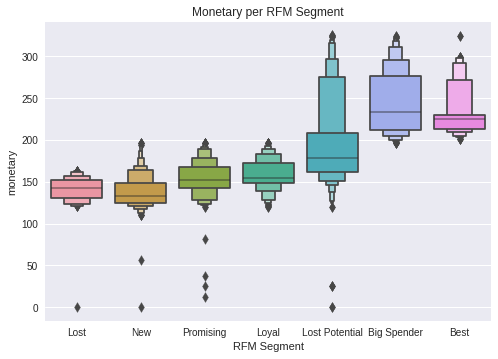

In [ ]:
sns.boxenplot(x=cust_df['RFM Segment'], y=cust_df['monetary'])
plt.title('Monetary per RFM Segment')

> Keterangan :
1. **Best Customers**:
  - Segmen ini terdiri dari 176 *customers*
  - *Customers* dapat dikatakan **Best Customers** melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 231 dengan rata-rata frekuensi transaksi 8 kali, dan rata-rata waktu terakhir pembelian sekitar 2.6 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.1
  - Pada segmen ini *customers* paling banyak membeli kategori Fashion dengan metode pembayaran credit card.
  - Treatment yang diberikan adalah loyalty program/reward point, rekomendasi produk baru, dan penawaran barang eksklusif. (Cross / Up Selling Strategy)
  
> 2. **Loyal Customers**:
  - Segmen ini terdiri dari 501 *customers*
  - *Customers* yang melakukan transaksi paling sering. 
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 158 dengan rata-rata frekuensi transaksi 5 kali, dan rata-rata waktu terakhir pembelian sekitar 4.8 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 2.9
  - Pada segmen ini *customers* paling banyak membeli kategori Laptop & Accessory dengan metode pembayaran credit card.
  - Treatment yang diberikan adalah loyalty program/reward point dan penawaran barang eksklusif (Cross / Up Selling Strategy).

> 3. **Big Spenders Customers**:
  - Segmen ini terdiri dari 712 *customers*
  - *Customers* yang mempunya total transaksi paling tinggi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 245 dengan rata-rata frekuensi transaksi 3 kali, dan rata-rata waktu terakhir pembelian sekitar 3 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3
  - Pada segmen ini *customers* paling banyak membeli kategori Fashion dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah	rekomendasi barang eksklusif, penawaran partnership/membership (B2B), dan penawaran pembelian dengan harga grosir (Cross / Up Selling Strategy)

> 4. **New Customers**:
  - Segmen ini terdiri dari 888 *customers*
  - *Customers* yang baru-baru ini melakukan transaksi dan baru satu kali melakukan transaksi.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 138 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 1 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.1
  - Pada segmen ini *customers* paling banyak membeli kategori Mobile Phone dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah welcome e-mail untuk membangun reletionship, penawaran loyalty program/reward point, dan voucher diskon (Cross / Up Selling Strategy)

> 5. **Promising Customers**:
  - Segmen ini terdiri dari 1336 *customers*
  - *Customers* yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 153 dengan rata-rata frekuensi transaksi 2 kali, dan rata-rata waktu terakhir pembelian sekitar 2 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.1
  - Pada segmen ini *customers* paling banyak membeli kategori Mobile Phone dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention Strategy)

> 6. **Lost Potential Customers**:
  - Segmen ini terdiri dari 1671 *customers*
  - *Customers* yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 195 dengan rata-rata frekuensi transaksi 4 kali, dan rata-rata waktu terakhir pembelian sekitar 8.4 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.1
  - Pada segmen ini *customers* paling banyak membeli kategori Laptop & Accessory dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention & Reactivate Stretegies)

> 7. **Lost Customers**:
  - Segmen ini terdiri dari 346 *customers*
  - *Customers* yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.
  - Pada segmen ini rata-rata total transaksi tiap customer di sekitar R\$ 141 dengan rata-rata frekuensi transaksi 1 kali, dan rata-rata waktu terakhir pembelian sekitar 6 hari.
  - *Customers* pada segmen ini memberikan rata-rata *review score* 3.1
  - Pada segmen ini *customers* paling banyak membeli kategori Laptop & Accessory dengan metode pembayaran credit card.
  - Treatment yang dapat diberikan adalah campaign via e-mail dan meminta feedback. (Reactivation Strategy)

> # Conclusion:
- Berdasarkan 3 model tersebut, setiap model memiliki kelemahan dan keunggulannya tersendiri:
  1. RFM Segmentation:
  - Advantages:
    - Model ini merupakan model yang memiliki interpretasi paling tinggi dibandingkan model lain, karena model ini dibuat dengan *domain knowledge* yang kami punya
  - Disadvantages:
    - Apabila diukur secara kuantitatif dengan silhoutte score, model ini merupakan model yang paling rendah
  2. K-Means:
  - Advantages:
    - Model K-Means merupakan model yang secara visualisasi tidak terlalu buruk dan secara silhoutte score tidak terlalu buruk juga
  - Disadvantages:
    - Pada segmentasi model K-Means, ada beberapa *customer* yang segmentasinya kurang spesifik, karena jumlah *cluster* hanya ditentukan dari Silhoutte Score
  3. Gaussians:
  - Advantages:
    - Model Gaussians secara kuantitatif merupakan model yang paling bagus
  - Disadvantages:
    - Model ini merupakan model yang paling sulit untuk diinterpretasi karena segmentasi dari hasil model ini tidak terlihat jelas

> - Berdasarkan point di atas, kami memutuskan untuk menggunakan model *RFM Segmentation* karena model ini merupakan model yang memiliki interpretasi yang paling tinggi.
- Model *RFM Segmentation* membagi *cluster* menjadi 7 *cluster*, Best, Loyal, Big Spender, New, Promising, Lost Potential, dan Lost

# Business Recommendation:

| RFM Segment    | Deskripsi                                                                                                                       | Strategi                                                             |
|----------------|---------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|
| Best           | Customers yang melakukan transaksi baru-baru ini, sering melakukan transaksi, dan mempunyai total transaksi yang paling tinggi. |  Loyalty program/reward point, rekomendasi produk baru, dan penawaran barang eksklusif (Cross / Up Selling Strategy)           |
| Loyal          | Customers yang melakukan transaksi paling sering.                                                                               |  Loyalty program/reward point dan penawaran barang eksklusif (Cross / Up Selling Strategy)         |
| Big Spender    | Customers yang mempunya total transaksi paling tinggi.                                                       | Rekomendasi barang eksklusif, penawaran partnership/membership (B2B), dan penawaran pembelian dengan harga grosir (Cross / Up Selling Strategy)                |
| New            | Customers yang baru-baru ini melakukan transaksi dan baru satu kali melakukan transaksi.                                        | Welcome e-mail untuk membangun reletionship, penawaran loyalty program/reward point, dan voucher diskon (Cross / Up Selling Strategy) |
| Promising      | Customers yang baru-baru ini melakukan transaksi, serta frekuensi dan total transaksinya diatas rata-rata customers lain.       |  Penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention Strategy)                       |
| Lost Potential | Customers yang sudah lama tidak melakukan transaksi, tetapi frekuensi dan total transaksinya diatas rata-rata customers lain.   | Penawaran terbatas secara rutin, voucher diskon dan cashback via e-mail (Retention & Reactivate Stretegies)                   |
| Lost           | Customers yang sudah lama tidak melakukan transaksi, hanya melakukan satu kali transaksi, dan total transaksi sedikit.          | Campaign via e-mail dan meminta feedback. (Reactivation Strategy)                                            |

# Import Data From Survival Analysis

In [ ]:
index_target_treatment = [39, 45, 47, 101, 176, 193,  229,  244,  371,  548,  638,
             690,  737,  796, 1043, 1072, 1266, 1311, 1431, 1515, 1517, 1646,
            1714, 1841, 2018, 2160, 2266, 2513, 2736, 2860, 2916, 2991, 3008,
            3044, 3059, 3186, 3363, 3505, 3611, 3887, 4081, 4126, 4461, 4529,
            4656, 4833, 4975, 5081, 5551]

In [ ]:
cust_target_treatment = cust_df.iloc[index_target_treatment]

In [ ]:
estimated = pd.DataFrame({39: {'Exp_Loss': 2513.2,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 125.66},
 45: {'Exp_Loss': 1697.5400000000002,
  'PreferedOrderCat_Grocery Uplift': 130.58,
  'PreferredPaymentMode_Credit Card Uplift': 522.32,
  'PreferredPaymentMode_Debit Card Uplift': 391.74},
 47: {'Exp_Loss': 2175.84,
  'PreferedOrderCat_Grocery Uplift': 120.88,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 120.88},
 101: {'Exp_Loss': 0.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 176: {'Exp_Loss': 1568.0,
  'PreferedOrderCat_Grocery Uplift': 224.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 448.0},
 193: {'Exp_Loss': 1746.92,
  'PreferedOrderCat_Grocery Uplift': 124.78,
  'PreferredPaymentMode_Credit Card Uplift': 499.12,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 229: {'Exp_Loss': 2357.76,
  'PreferedOrderCat_Grocery Uplift': 147.36,
  'PreferredPaymentMode_Credit Card Uplift': 147.36,
  'PreferredPaymentMode_Debit Card Uplift': 147.36},
 244: {'Exp_Loss': 1518.84,
  'PreferedOrderCat_Grocery Uplift': 253.14,
  'PreferredPaymentMode_Credit Card Uplift': 379.71,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 371: {'Exp_Loss': 1613.6399999999999,
  'PreferedOrderCat_Grocery Uplift': 134.47,
  'PreferredPaymentMode_Credit Card Uplift': 403.40999999999997,
  'PreferredPaymentMode_Debit Card Uplift': 403.40999999999997},
 548: {'Exp_Loss': 1279.9,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 383.97,
  'PreferredPaymentMode_Debit Card Uplift': 255.98000000000002},
 638: {'Exp_Loss': 2321.7999999999997,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 122.19999999999999,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 690: {'Exp_Loss': 1448.3999999999999,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 120.69999999999999,
  'PreferredPaymentMode_Debit Card Uplift': 120.69999999999999},
 737: {'Exp_Loss': 2212.2000000000003,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 122.9,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 796: {'Exp_Loss': 1944.6399999999999,
  'PreferedOrderCat_Grocery Uplift': 121.53999999999999,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 243.07999999999998},
 1043: {'Exp_Loss': 2201.6,
  'PreferedOrderCat_Grocery Uplift': 275.2,
  'PreferredPaymentMode_Credit Card Uplift': 550.4,
  'PreferredPaymentMode_Debit Card Uplift': 550.4},
 1072: {'Exp_Loss': 1909.2,
  'PreferedOrderCat_Grocery Uplift': 127.28,
  'PreferredPaymentMode_Credit Card Uplift': 509.12,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 1266: {'Exp_Loss': 1157.22,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 128.58,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 1311: {'Exp_Loss': 123.80000000000001,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 1431: {'Exp_Loss': 2341.18,
  'PreferedOrderCat_Grocery Uplift': 123.22,
  'PreferredPaymentMode_Credit Card Uplift': 246.44,
  'PreferredPaymentMode_Debit Card Uplift': 246.44},
 1515: {'Exp_Loss': 2350.44,
  'PreferedOrderCat_Grocery Uplift': 130.58,
  'PreferredPaymentMode_Credit Card Uplift': 261.16,
  'PreferredPaymentMode_Debit Card Uplift': 261.16},
 1517: {'Exp_Loss': 2296.72,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 120.88},
 1646: {'Exp_Loss': 2128.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 112.0},
 1714: {'Exp_Loss': 1518.84,
  'PreferedOrderCat_Grocery Uplift': 126.57,
  'PreferredPaymentMode_Credit Card Uplift': 379.71,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 1841: {'Exp_Loss': 1613.6399999999999,
  'PreferedOrderCat_Grocery Uplift': 134.47,
  'PreferredPaymentMode_Credit Card Uplift': 403.40999999999997,
  'PreferredPaymentMode_Debit Card Uplift': 403.40999999999997},
 2018: {'Exp_Loss': 1279.9,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 255.98000000000002,
  'PreferredPaymentMode_Debit Card Uplift': 255.98000000000002},
 2160: {'Exp_Loss': 1448.3999999999999,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 120.69999999999999,
  'PreferredPaymentMode_Debit Card Uplift': 120.69999999999999},
 2266: {'Exp_Loss': 1944.6399999999999,
  'PreferedOrderCat_Grocery Uplift': 121.53999999999999,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 243.07999999999998},
 2513: {'Exp_Loss': 2201.6,
  'PreferedOrderCat_Grocery Uplift': 275.2,
  'PreferredPaymentMode_Credit Card Uplift': 550.4,
  'PreferredPaymentMode_Debit Card Uplift': 550.4},
 2736: {'Exp_Loss': 1157.22,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 128.58,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 2860: {'Exp_Loss': 2800.44,
  'PreferedOrderCat_Grocery Uplift': 155.58,
  'PreferredPaymentMode_Credit Card Uplift': 155.58,
  'PreferredPaymentMode_Debit Card Uplift': 155.58},
 2916: {'Exp_Loss': 225.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 25.0,
  'PreferredPaymentMode_Debit Card Uplift': 25.0},
 2991: {'Exp_Loss': 2603.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 137.0},
 3008: {'Exp_Loss': 2845.82,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 149.78,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 3044: {'Exp_Loss': 2757.76,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 172.36,
  'PreferredPaymentMode_Debit Card Uplift': 172.36},
 3059: {'Exp_Loss': 1818.84,
  'PreferedOrderCat_Grocery Uplift': 151.57,
  'PreferredPaymentMode_Credit Card Uplift': 303.14,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 3186: {'Exp_Loss': 2870.46,
  'PreferedOrderCat_Grocery Uplift': 159.47,
  'PreferredPaymentMode_Credit Card Uplift': 159.47,
  'PreferredPaymentMode_Debit Card Uplift': 159.47},
 3363: {'Exp_Loss': 1529.9,
  'PreferedOrderCat_Grocery Uplift': 152.99,
  'PreferredPaymentMode_Credit Card Uplift': 305.98,
  'PreferredPaymentMode_Debit Card Uplift': 305.98},
 3505: {'Exp_Loss': 1748.3999999999999,
  'PreferedOrderCat_Grocery Uplift': 145.7,
  'PreferredPaymentMode_Credit Card Uplift': 145.7,
  'PreferredPaymentMode_Debit Card Uplift': 145.7},
 3611: {'Exp_Loss': 2344.64,
  'PreferedOrderCat_Grocery Uplift': 146.54,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 293.08},
 3887: {'Exp_Loss': 2893.32,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 152.28,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 4081: {'Exp_Loss': 1228.64,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 153.58,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 4126: {'Exp_Loss': 1339.2,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 297.6},
 4461: {'Exp_Loss': 2603.0,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 137.0},
 4529: {'Exp_Loss': 1667.27,
  'PreferedOrderCat_Grocery Uplift': 303.14,
  'PreferredPaymentMode_Credit Card Uplift': 454.71,
  'PreferredPaymentMode_Debit Card Uplift': 0.0},
 4656: {'Exp_Loss': 2870.46,
  'PreferedOrderCat_Grocery Uplift': 159.47,
  'PreferredPaymentMode_Credit Card Uplift': 159.47,
  'PreferredPaymentMode_Debit Card Uplift': 159.47},
 4833: {'Exp_Loss': 1529.9,
  'PreferedOrderCat_Grocery Uplift': 152.99,
  'PreferredPaymentMode_Credit Card Uplift': 305.98,
  'PreferredPaymentMode_Debit Card Uplift': 305.98},
 4975: {'Exp_Loss': 1748.3999999999999,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 145.7,
  'PreferredPaymentMode_Debit Card Uplift': 145.7},
 5081: {'Exp_Loss': 2344.64,
  'PreferedOrderCat_Grocery Uplift': 146.54,
  'PreferredPaymentMode_Credit Card Uplift': 0.0,
  'PreferredPaymentMode_Debit Card Uplift': 293.08},
 5551: {'Exp_Loss': 1228.64,
  'PreferedOrderCat_Grocery Uplift': 0.0,
  'PreferredPaymentMode_Credit Card Uplift': 153.58,
  'PreferredPaymentMode_Debit Card Uplift': 0.0}})

In [ ]:
target_treatment = pd.concat([cust_target_treatment, estimated.T], axis = 1)
target_treatment

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,M,RFM Score,RFM Segment,RFM Segment Score,label k-means,label gaussian,Exp_Loss,PreferedOrderCat_Grocery Uplift,PreferredPaymentMode_Credit Card Uplift,PreferredPaymentMode_Debit Card Uplift
39,50040,0,0.0,Computer,1,9.0,Credit Card,Male,3.0,4,...,1,411,New,4,Lost,2,2513.20,0.00,0.00,125.66
45,50046,0,0.0,Mobile Phone,1,23.0,Cash on Delivery,Male,3.0,3,...,1,411,New,4,Lost,2,1697.54,130.58,522.32,391.74
47,50048,0,1.0,Computer,1,9.0,Credit Card,Male,1.0,3,...,1,441,Promising,3,Loyal,1,2175.84,120.88,0.00,120.88
101,50102,0,10.0,Computer,3,10.0,E wallet,Male,2.0,3,...,1,141,Lost Potential,2,Loyal,1,0.00,0.00,0.00,0.00
176,50177,0,0.0,Mobile Phone,3,16.0,Credit Card,Female,3.0,4,...,1,411,New,4,Lost,2,1568.00,224.00,0.00,448.00
193,50194,0,0.0,Mobile Phone,1,9.0,Debit Card,Female,2.0,3,...,1,411,New,4,Lost,2,1746.92,124.78,499.12,0.00
229,50230,0,3.0,Computer,3,31.0,Cash on Delivery,Female,2.0,3,...,2,422,Promising,3,Lost,2,2357.76,147.36,147.36,147.36
244,50245,0,4.0,Mobile Phone,1,9.0,Debit Card,Male,2.0,4,...,1,421,Promising,3,Lost,2,1518.84,253.14,379.71,0.00
371,50372,0,0.0,Mobile Phone,3,28.0,Cash on Delivery,Male,2.0,3,...,1,411,New,4,Lost,2,1613.64,134.47,403.41,403.41
548,50549,0,6.0,Mobile Phone,1,6.0,UPI,Male,3.0,4,...,1,411,New,4,Lost,2,1279.90,0.00,383.97,255.98


Text(0.5, 1.0, 'Recency per RFM Segment')

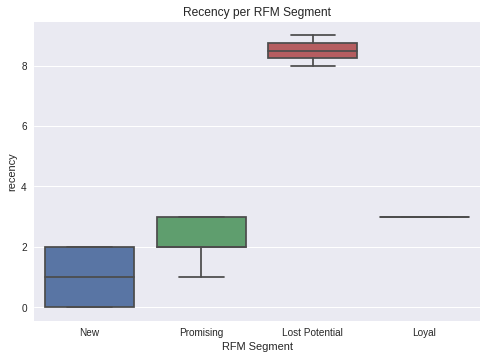

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['recency'])
plt.title('Recency per RFM Segment')

Text(0.5, 1.0, 'Frequency per RFM Segment')

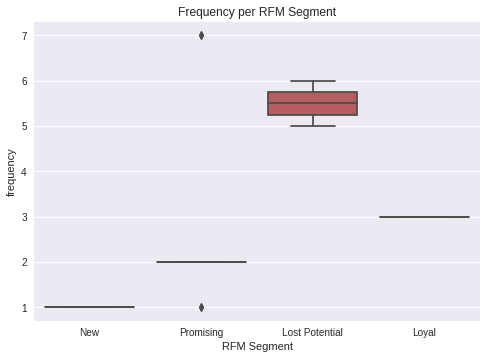

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['frequency'])
plt.title('Frequency per RFM Segment')

Text(0.5, 1.0, 'Monetary per RFM Segment')

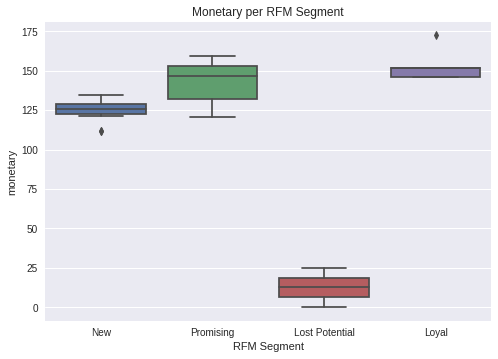

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['monetary'])
plt.title('Monetary per RFM Segment')

Text(0.5, 1.0, 'Exp_Loss per RFM Segment')

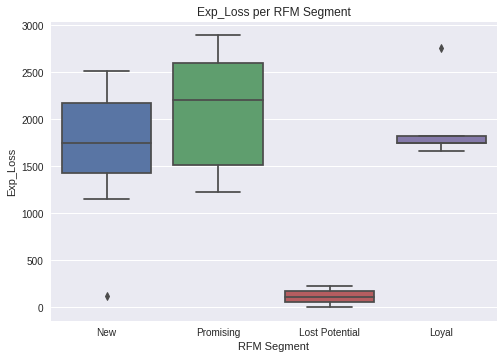

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['Exp_Loss'])
plt.title('Exp_Loss per RFM Segment')

Text(0.5, 1.0, 'PreferedOrderCat_Grocery Uplift per RFM Segment')

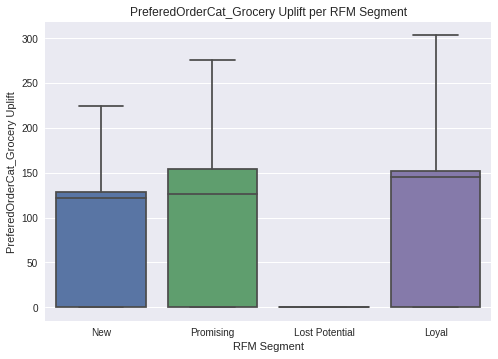

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['PreferedOrderCat_Grocery Uplift'])
plt.title('PreferedOrderCat_Grocery Uplift per RFM Segment')

Text(0.5, 1.0, 'PreferredPaymentMode_Credit Card Uplift per RFM Segment')

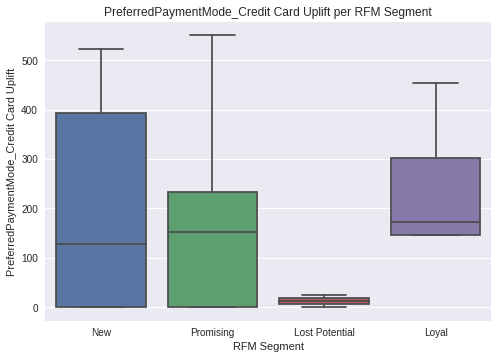

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['PreferredPaymentMode_Credit Card Uplift'])
plt.title('PreferredPaymentMode_Credit Card Uplift per RFM Segment')

Text(0.5, 1.0, 'PreferredPaymentMode_Debit Card Uplift per RFM Segment')

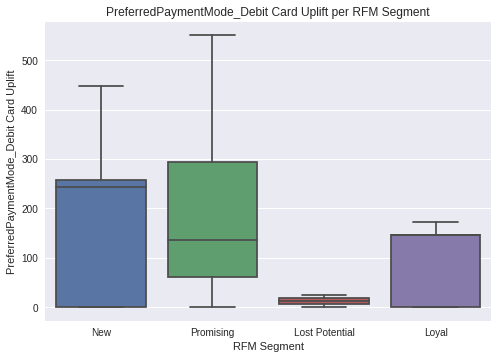

In [ ]:
sns.boxplot(x=target_treatment['RFM Segment'], y=target_treatment['PreferredPaymentMode_Debit Card Uplift'])
plt.title('PreferredPaymentMode_Debit Card Uplift per RFM Segment')

In [ ]:
target_treatment.groupby(['RFM Segment', 'RFM Segment Score']).agg(
    n_customer = ('CustomerID', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('PreferredPaymentMode', lambda x: x.value_counts().index[0]),
    avg_review_score = ('SatisfactionScore', 'mean'),
    most_product_buy = ('PreferedOrderCat', lambda x: x.value_counts().index[0]),
    sum_Exp_Loss =  ('Exp_Loss', 'sum'),
    sum_PreferedOrderCat_Grocery_Uplift = ('PreferedOrderCat_Grocery Uplift', 'sum'),
    sum_PreferredPaymentMode_Credit_Card_Uplift = ('PreferredPaymentMode_Credit Card Uplift', 'sum'),
    sum_PreferredPaymentMode_Debit_Card_Uplift = ('PreferredPaymentMode_Debit Card Uplift', 'sum'),
).sort_values(by='RFM Segment Score', ascending=False)

,,n_customer,mean_recency,min_recency,max_rencency,mean_freq,min_freq,max_freq,mean_monetary,min_monetary,max_monetary,most_payment_type,avg_review_score,most_product_buy,sum_Exp_Loss,sum_PreferedOrderCat_Grocery_Uplift,sum_PreferredPaymentMode_Credit_Card_Uplift,sum_PreferredPaymentMode_Debit_Card_Uplift
RFM Segment,RFM Segment Score,,,,,,,,,,,,,,,,,
Loyal,6,5,3.000000,3.0,3.0,3.000000,3.0,3.0,153.380000,145.7,172.36,Cash on Delivery,3.800000,Mobile Phone,9740.67,600.41,1221.61,463.76
New,4,19,1.105263,0.0,2.0,1.000000,1.0,1.0,125.271579,112.0,134.47,Credit Card,3.894737,Mobile Phone,32903.08,1372.46,3987.19,3389.94
Promising,3,23,2.304348,1.0,3.0,2.347826,1.0,7.0,141.933043,120.7,159.47,Cash on Delivery,3.695652,Mobile Phone,48200.06,2271.93,3944.68,3975.56
Lost Potential,2,2,8.500000,8.0,9.0,5.500000,5.0,6.0,12.500000,0.0,25.00,E wallet,2.000000,Mobile Phone,225.00,0.00,25.00,25.00
